In [64]:
import os
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# cargar modelo de lenguaje de spacy para español
nlp = spacy.load("es_core_news_sm")

# cargar archivos de discurso
discursos = []
for filename in ["1erinforme.txt", "2doinforme.txt", "3erinforme.txt", "4toinforme.txt"]:
    with open(filename, "r", encoding="utf-8") as f:
        discursos.append(f.read())

In [65]:
len(discursos)

4

### Lematización y Tokenización

In [66]:
from nltk.stem import WordNetLemmatizer

# definir el lematizador para español
lemmatizer = WordNetLemmatizer()

# tokenizar y normalizar el texto
stop_words = set(stopwords.words('spanish'))

# agregar palabras específicas
stop_words.update(['mil', 'millones', 'año'])

tokens = []
for discurso in discursos:
    doc = nlp(discurso)
    for token in doc:
        if not token.is_punct and not token.is_stop:
            lemma = lemmatizer.lemmatize(token.text.lower(), pos='v')
            if lemma not in stop_words and not all(c.isspace() for c in lemma):
                tokens.append(lemma)

# filtrar los elementos vacíos de la lista
tokens = list(filter(lambda x: len(x) > 0, tokens))

In [67]:
print(len(tokens))
tokens[:15]

9178


['tomé',
 'posesión',
 'presidencia',
 'república',
 'diciembre',
 '9',
 'meses',
 'sostuve',
 'asumía',
 'compromiso',
 'convocar',
 'ciudadanos',
 'emprender',
 'juntos',
 'cuarta']

## Analisis de Frecuencias

In [68]:
from nltk import FreqDist

# Calculando la frecuencia de las palabras
fdist = FreqDist(tokens)

# Imprimiendo las 10 palabras más comunes
print(fdist.most_common(20))

[('méxico', 81), ('ciento', 79), ('gobierno', 66), ('país', 62), ('pesos', 51), ('pueblo', 50), ('bienestar', 43), ('nacional', 38), ('pública', 31), ('años', 31), ('pobres', 28), ('construcción', 28), ('pandemia', 28), ('federal', 27), ('programa', 27), ('corrupción', 26), ('política', 25), ('desarrollo', 24), ('seguridad', 24), ('dólares', 23)]


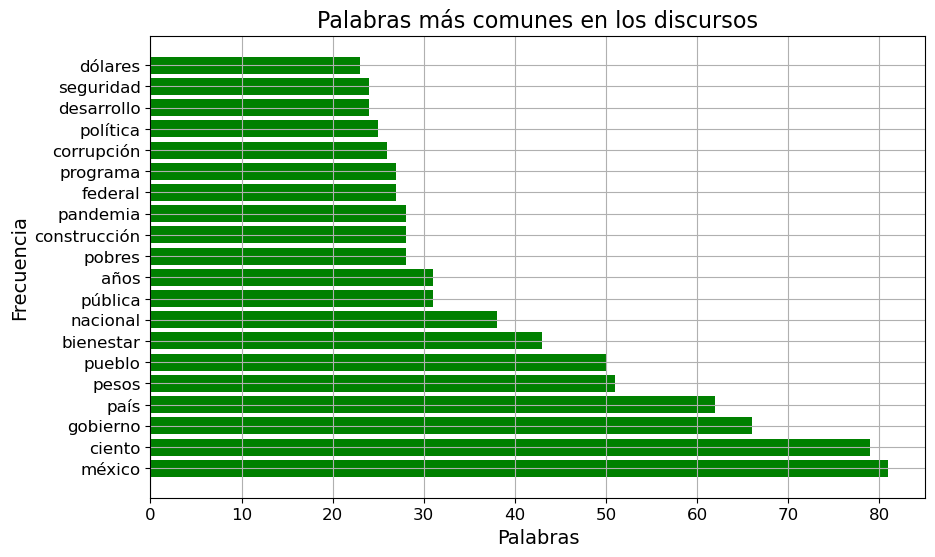

In [69]:
# Obtener las 10 palabras más comunes
top_words = dict(fdist.most_common(20))

# Convertir las claves a una lista
word_list = list(top_words.keys())

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras
ax.barh(word_list, top_words.values(), color='g')

# Personalizar la figura
ax.set_title('Palabras más comunes en los discursos', fontsize=16)
ax.set_xlabel('Palabras', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

# Mostrar la figura
plt.show()

Es muy interesante el uso de la palabra "ciento", ya que eso implica que en multiples ocasiones el presidente hace referencias a porcentajes, es decir, a proporciones. Esa es una manera en que los receptores del discurso puedan darse una idea más clara de las proporciones que él manera

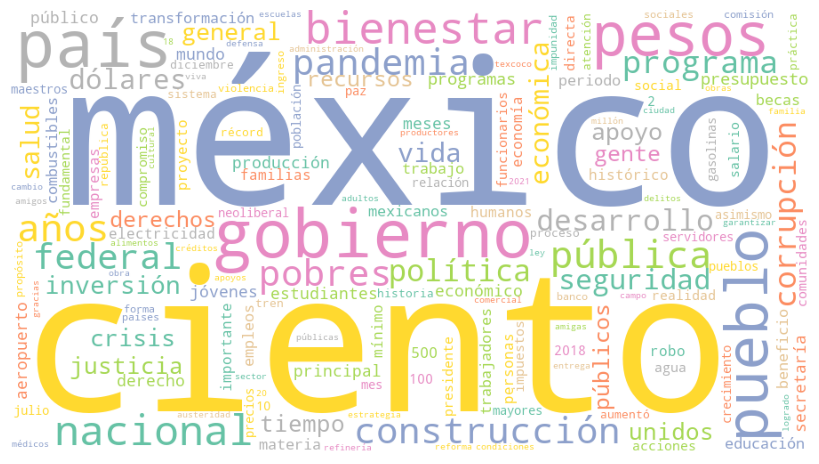

In [70]:
import random

# importando las paletas de colores
from palettable.colorbrewer.qualitative import Set2_8

# creando una lista de colores a partir de la paleta Set2
color_list = [tuple(rgb) for rgb in Set2_8.colors]

# Generando una wordcloud con la nueva paleta de colores
wordcloud = WordCloud(width=900, height=500, background_color='white', stopwords=stopwords,
                      min_font_size=10, colormap='Set2', color_func=lambda *args, **kwargs: color_list[random.randint(0, 7)]).generate_from_frequencies(fdist)

# Mostrando la imagen
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

## Analisis de Sentimiento

In [71]:
sia = SentimentIntensityAnalyzer()
scores = []

#Se itera sobre la primera lista de discursos
for discurso in discursos:
    score = sia.polarity_scores(discurso)
    scores.append(score["compound"])



# imprimir puntajes de sentimiento
for i, score in enumerate(scores):
    print(f"Discurso {i+1}: {score}")

Discurso 1: -0.9977
Discurso 2: -0.9978
Discurso 3: -0.9984
Discurso 4: -0.953


El resultado del análisis de sentimientos muestra que los cuatro discursos tienen puntajes de sentimiento negativos ya que los cuatro se encuentran muy cercanos al valor de -1

## Identificación de Temas Principales

In [75]:
# Importar librerías necesarias
from gensim import corpora, models
import numpy as np

# Crear una lista de diccionarios, donde cada diccionario representa un discurso
dict_list = []
for i, discurso in enumerate(discursos):
    dict_list.append({"id": i, "texto": ' '.join(tokens)})

# Crear un diccionario de términos a partir de los discursos
dictionary = corpora.Dictionary([doc["texto"].split() for doc in dict_list])

# Crear un corpus (lista de bolsas de palabras) a partir del diccionario
corpus = [dictionary.doc2bow(doc["texto"].split()) for doc in dict_list]

# Crear un modelo LDA con 5 tópicos
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics=5,
                                     passes=10,
                                     alpha='auto')

# Imprimir los tópicos más importantes para cada discurso
for doc in dict_list:
    bow = dictionary.doc2bow(doc["texto"].split())
    topics = lda_model[bow]
    top_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:3]
    print(f"Discurso {doc['id'] + 1}: {', '.join([f'Tópico {topic[0]+1} ({round(topic[1]*100, 2)}%)' for topic in top_topics])}")

Discurso 1: Tópico 2 (99.99%)
Discurso 2: Tópico 2 (99.99%)
Discurso 3: Tópico 2 (99.99%)
Discurso 4: Tópico 2 (99.99%)


Usamos la función print_topics() del modelo LDA entrenado, para mostrar las palabras más representativas de cada tópico, ordenados de mayor a menor importancia.

In [83]:
for idx, topic in lda_model.print_topics(num_topics=5, num_words=10):
    print('Tópico: {} \nPalabras más importantes: {}'.format(idx+1, topic))

Tópico: 1 
Palabras más importantes: 0.003*"méxico" + 0.002*"ciento" + 0.002*"país" + 0.002*"gobierno" + 0.002*"pesos" + 0.001*"pueblo" + 0.001*"bienestar" + 0.001*"nacional" + 0.001*"dólares" + 0.001*"programa"
Tópico: 2 
Palabras más importantes: 0.009*"méxico" + 0.008*"ciento" + 0.007*"gobierno" + 0.007*"país" + 0.005*"pesos" + 0.005*"pueblo" + 0.005*"bienestar" + 0.004*"nacional" + 0.003*"años" + 0.003*"pública"
Tópico: 3 
Palabras más importantes: 0.001*"méxico" + 0.001*"país" + 0.001*"pesos" + 0.001*"ciento" + 0.001*"pueblo" + 0.001*"gobierno" + 0.001*"bienestar" + 0.000*"pública" + 0.000*"federal" + 0.000*"construcción"
Tópico: 4 
Palabras más importantes: 0.001*"ciento" + 0.001*"méxico" + 0.001*"país" + 0.001*"gobierno" + 0.001*"pesos" + 0.001*"nacional" + 0.001*"pueblo" + 0.001*"bienestar" + 0.001*"años" + 0.001*"pandemia"
Tópico: 5 
Palabras más importantes: 0.001*"ciento" + 0.001*"méxico" + 0.001*"gobierno" + 0.001*"pueblo" + 0.001*"país" + 0.001*"pesos" + 0.001*"bienestar" 

In [82]:
import pandas as pd

num_topics=5 
num_words=15
# Creamos una lista con los datos de cada tópico
topicos = []
for idx, topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words):
    topicos.append([f"Tópico {idx+1}", ", ".join([word[0] for word in topic])])

# Creamos el dataframe con los datos de los tópicos y las palabras más importantes
df_topicos = pd.DataFrame(topicos, columns=["Tópico", "Palabras más importantes"])

# Imprimimos el dataframe
print(df_topicos)

     Tópico                           Palabras más importantes
0  Tópico 1  méxico, ciento, país, gobierno, pesos, pueblo,...
1  Tópico 2  méxico, ciento, gobierno, país, pesos, pueblo,...
2  Tópico 3  méxico, país, pesos, ciento, pueblo, gobierno,...
3  Tópico 4  ciento, méxico, país, gobierno, pesos, naciona...
4  Tópico 5  ciento, méxico, gobierno, pueblo, país, pesos,...
